# Data tutorial - llc4320_ml_ssh2uv

* Notebook creator: Jinbo Wang
* Data creator: Ou Wang
* LLC4320 project: Dimitris Menemenlis et al.

This note book is written to be run on AWS cloud environment hosted by hub.openveda.cloud or similar platforms such as those maintained by 2i2c. 

Before running this notebook, make sure you run "aws configure" from command line and input the AWS Access ID and Keys. They can be found in the workshop slack channel. 

This dataset can be used to train a model for SWOT denoising, SWOT interpolation of the Nadir gap and coruppted values such as those due to rain, eddy-wave separation etc. 

05/18/2025

## Load and examine data directly from S3

The s3fs module, provided by AWS, allows Python to interact with S3 as if it were a local filesystem. It’s essential for reading files (like NetCDF) from S3 buckets. Below is a complete example demonstrating the specific operations needed to use s3fs to load a NetCDF file, with Dask for lazy loading and an option to convert to Zarr.

In [51]:
import s3fs
import xarray as xr
import numpy as np
# Initialize S3 filesystem
s3 = s3fs.S3FileSystem(anon=False,profile='default') #read only access
s3_path = "s3://odsl/nasa_oceanai_workshop2025/llc4320_ml_ssh2uv/*nc"

# Open dataset with Dask chunking
file_names = s3.glob(s3_path)
display(file_names[:20])

['odsl/nasa_oceanai_workshop2025/llc4320_ml_ssh2uv/ECCO_LLC4320_native_IO_1x1_hour_mean_0000010368_SWOT_coords_complete_asc.nc',
 'odsl/nasa_oceanai_workshop2025/llc4320_ml_ssh2uv/ECCO_LLC4320_native_IO_1x1_hour_mean_0000010512_SWOT_coords_complete_asc.nc',
 'odsl/nasa_oceanai_workshop2025/llc4320_ml_ssh2uv/ECCO_LLC4320_native_IO_1x1_hour_mean_0000010656_SWOT_coords_complete_asc.nc',
 'odsl/nasa_oceanai_workshop2025/llc4320_ml_ssh2uv/ECCO_LLC4320_native_IO_1x1_hour_mean_0000010800_SWOT_coords_complete_asc.nc',
 'odsl/nasa_oceanai_workshop2025/llc4320_ml_ssh2uv/ECCO_LLC4320_native_IO_1x1_hour_mean_0000010944_SWOT_coords_complete_asc.nc',
 'odsl/nasa_oceanai_workshop2025/llc4320_ml_ssh2uv/ECCO_LLC4320_native_IO_1x1_hour_mean_0000011088_SWOT_coords_complete_asc.nc',
 'odsl/nasa_oceanai_workshop2025/llc4320_ml_ssh2uv/ECCO_LLC4320_native_IO_1x1_hour_mean_0000011232_SWOT_coords_complete_asc.nc',
 'odsl/nasa_oceanai_workshop2025/llc4320_ml_ssh2uv/ECCO_LLC4320_native_IO_1x1_hour_mean_000001137

## Load data using xarray 

In [13]:
nc_data=xr.open_dataset(s3.open(file_names[0],mode='rb'), engine='h5netcdf',)
nc_data

<xarray.Dataset> Size: 460MB
Dimensions:     (time: 1, k: 2, num_lines: 4009, num_pixels: 69, pass: 26)
Coordinates:
  * time        (time) datetime64[ns] 8B 2011-09-13
  * k           (k) int64 16B 0 16
  * num_lines   (num_lines) int64 32kB 1690 1691 1692 1693 ... 5696 5697 5698
  * num_pixels  (num_pixels) int64 552B 0 1 2 3 4 5 6 7 ... 62 63 64 65 66 67 68
  * pass        (pass) int64 208B 0 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
    niter       (time) int64 8B ...
Data variables:
    U           (time, k, pass, num_lines, num_pixels) float64 115MB ...
    V           (time, k, pass, num_lines, num_pixels) float64 115MB ...
    Theta       (time, pass, num_lines, num_pixels) float64 58MB ...
    Eta         (time, pass, num_lines, num_pixels) float64 58MB ...
    oceTAUX     (time, pass, num_lines, num_pixels) float64 58MB ...
    oceTAUY     (time, pass, num_lines, num_pixels) float64 58MB ...

## Visualize a 69x69 segment

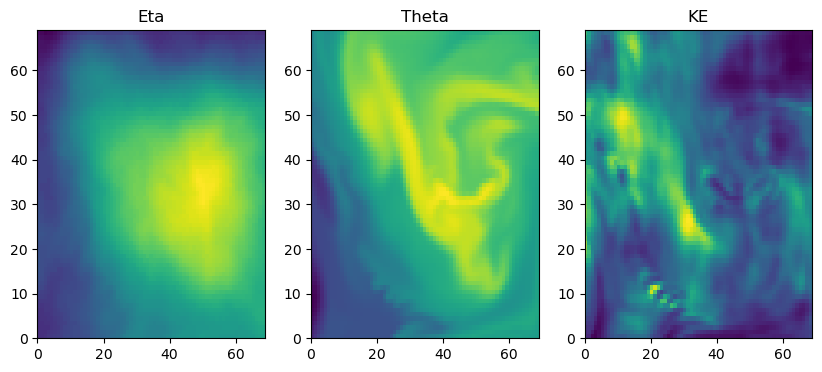

In [43]:
import pylab as plt 

j0,j1=200,269
fig,ax=plt.subplots(1,3,figsize=(10,4))
data={'Eta':nc_data.Eta[0,0,j0:j1,:],
      'Theta':nc_data.Theta[0,0,j0:j1,:],
      'KE':nc_data.U[0,0,0,j0:j1,:]**2+nc_data.V[0,0,0,j0:j1,:]**2 } 

for i,key in enumerate(data.keys()):
    ax[i].pcolor(data[key])
    ax[i].set_title(key)
    

## Example: create a bunch of 69x69 segments

In [61]:
eta=nc_data.Eta.squeeze()[:,-60*60:,:] #skip the beginning grids to avoid getting into the sea ice zone. 
print(eta.shape)
npass,nlines,npixels=eta.shape 

#use the first 60 points in the cross-swath direction. 
eta_seg = eta[:,:,:60].data.reshape(npass,nlines//60,60,60).reshape(-1,60,60)
print("We get ",eta_seg.shape,"samples from one file")
# Shifting to the last 60 points may be used to create additional set of data. 
eta_seg = np.concatenate((eta_seg, eta[:,:,:60].data.reshape(npass,nlines//60,60,60).reshape(-1,60,60)),axis=0)
print("double the sample size by shifting 9 grid points in segmentation", eta_seg.shape)

(26, 3600, 69)
We get  (1560, 60, 60) samples from one file
double the sample size by shifting 9 grid points in segmentation (3120, 60, 60)


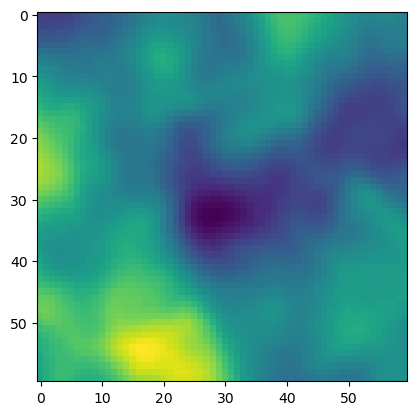

In [62]:
plt.imshow(eta_seg[100,...]) 